In [2]:
import os, sys, glob
from tqdm import tqdm
import avstack
import avapi
import cv2
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

image_dir = '../data/ADL-Rundle-6/img1/'
det_file = '../data/ADL-Rundle-6/det/det.txt'
gt_file = '../data/ADL-Rundle-6/gt/gt.txt'

Cannot import rss library


## Load Ground Truths

\<frame\>, \<id\>, \<bb_left\>, \<bb_top\>, \<bb_width\>, \<bb_height\>, \<conf\>, \<x\>, \<y\>, \<z\>


In [3]:
# Load up the ground truths
gt_boxes = []
last_frame = -1
obj_this_frame = None
with open(gt_file, 'r') as f:
    lines = f.read().splitlines()
    for line in lines:
        items = line.split(',')
        frame, ID, bb_left, bb_top, bb_width, bb_height, conf, x, y, z = map(float, items)
        if frame > last_frame:
            if obj_this_frame is not None:
                gt_boxes.append(obj_this_frame)
            obj_this_frame = []
        xmin = bb_left
        ymin = bb_top
        xmax = bb_left + bb_width
        ymax = bb_top + bb_height
        box2d = avstack.geometry.Box2D([xmin, ymin, xmax, ymax], avstack.calibration.NominalCalibration)
        obj_this_frame.append(box2d)
        last_frame = frame

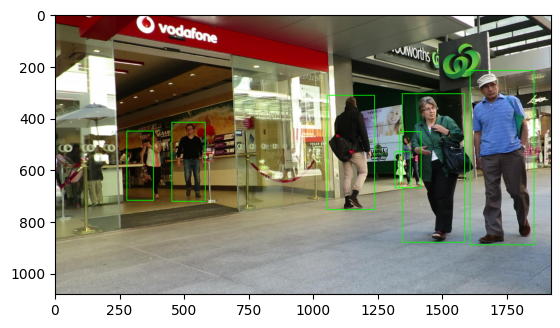

In [4]:
%matplotlib inline

def viz_image_with_boxes(i_frame, boxes):
    # Visualize some ground truths
    img1 = cv2.cvtColor(cv2.imread(os.path.join(image_dir, '%06d.jpg'%i_frame)), cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    for box in boxes:
        img1 = cv2.rectangle(
            img1,
            (int(box.xmin), int(box.ymin)),
            (int(box.xmax), int(box.ymax)),
            color,
            2,
        )

    # Show image
    plt.imshow(img1)
    plt.show()

# Run it
i_frame = 100
viz_image_with_boxes(i_frame, gt_boxes[i_frame-1])

## Run Algorithms

In [5]:
framerate = 30.0
detector = avstack.modules.perception.object2dfv.MMDetObjectDetector2D(model='fasterrcnn', dataset='coco-person')
tracker = avstack.modules.tracking.tracker2d.SortTracker2D(framerate)

/home/spencer/Documents/Projects/AVstack/platforms/demo-platform/.venv/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: /home/spencer/Documents/Projects/AVstack/platforms/demo-platform/third_party/lib-avstack-core/third_party/mmdetection/checkpoints/coco-person/faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth


In [7]:
all_dets = []
all_tracks = []
image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
n_frames = min(len(image_files), 50)
for frame, image_file in tqdm(enumerate(image_files[:n_frames]), total=n_frames):
    # -- load image in avstack standard format
    image_data = cv2.imread(image_file)
    timestamp = i_frame/framerate
    image = avstack.sensors.ImageData(timestamp=timestamp,
                                      frame=frame,
                                      source_ID=0,
                                      source_name='camera-0',
                                      data=image_data,
                                      calibration=avstack.calibration.NominalCalibration)
    
    # -- run detections and tracking
    dets = detector(image)
    tracks = tracker(dets, frame=frame, t=timestamp)
    
    # -- save results
    all_dets.append(dets)
    all_tracks.append(tracks)

100%|█████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.63it/s]


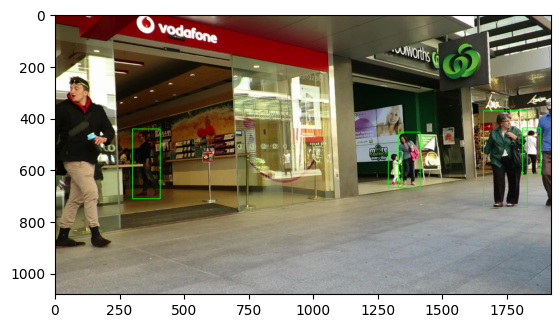

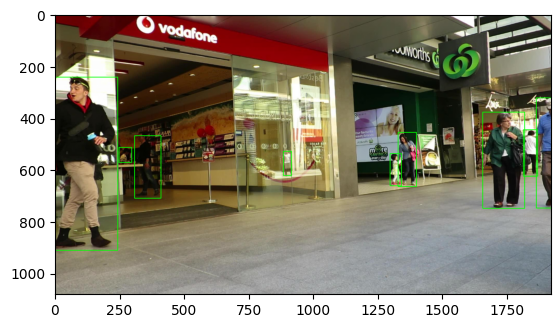

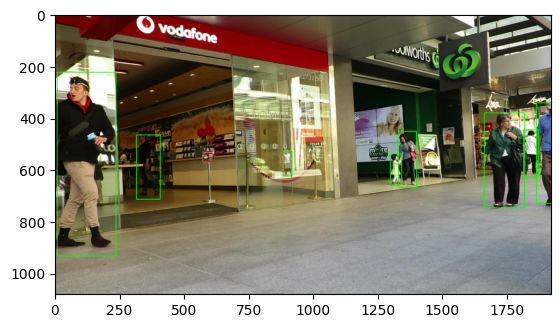

In [9]:
# ground truth vs real detections vs tracks
i_frame = 20
viz_image_with_boxes(i_frame, gt_boxes[i_frame-1])
viz_image_with_boxes(i_frame, [d.box for d in all_dets[i_frame-1]])
viz_image_with_boxes(i_frame, [t.box for t in all_tracks[i_frame-1]])